## Libraries

In [1]:
import sys
import os
import dandelion as ddl
import warnings
import scanpy as sc
from pie_plot import piechart #make sure this file is in current directory or change name
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

ddl.logging.print_versions()
warnings.filterwarnings("ignore")

dandelion==0.3.8 pandas==2.2.2 numpy==1.26.4 matplotlib==3.9.2 networkx==3.3 scipy==1.14.1


## Preprocessing

In [2]:
#change directory for software, how software handles file management is bad
os.chdir('input')
os.getcwd()

'/Users/nick/dandelion_analysis_2024-09-25/Input'

In [3]:
samples = ["homotypic"] #need to be identical to names of folders where data is kept. It is important to keep file system and naming consistent otherwise you will need to debug

In [4]:
# format fastas, can include a suffix if needed
ddl.pp.format_fastas(samples, prefix=samples)

Formatting fasta(s) : 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


In [5]:
# Reannotate the V/D/J genes with igblastn
ddl.pp.reannotate_genes(samples, org = "mouse")

Assigning genes :   0%|          | 0/1 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/bio/bin/MakeDb.py:124: SyntaxWarning: invalid escape sequence '\s'
  id_key = re.sub('\s|\t', '_', rec.description[:imgt_id_len])
/opt/homebrew/Caskroom/miniforge/base/envs/bio/bin/MakeDb.py:126: SyntaxWarning: invalid escape sequence '\|'
  id_key = re.sub('\||\s|!|&|\*|<|>|\?', '_', rec.description[:imgt_id_len])


         START> MakeDB
       COMMAND> igblast
  ALIGNER_FILE> filtered_contig_igblast.fmt7
      SEQ_FILE> filtered_contig.fasta
       ASIS_ID> False
    ASIS_CALLS> False
      VALIDATE> strict
      EXTENDED> True
INFER_JUNCTION> False

PROGRESS> 11:26:12 |Done                | 0.0 min

PROGRESS> 11:26:13 |####################| 100% (2,615) 0.0 min

OUTPUT> filtered_contig_igblast_db-pass.tsv
  PASS> 2615
  FAIL> 0
   END> MakeDb



/opt/homebrew/Caskroom/miniforge/base/envs/bio/bin/MakeDb.py:124: SyntaxWarning: invalid escape sequence '\s'
  id_key = re.sub('\s|\t', '_', rec.description[:imgt_id_len])
/opt/homebrew/Caskroom/miniforge/base/envs/bio/bin/MakeDb.py:126: SyntaxWarning: invalid escape sequence '\|'
  id_key = re.sub('\||\s|!|&|\*|<|>|\?', '_', rec.description[:imgt_id_len])


         START> MakeDB
       COMMAND> igblast
  ALIGNER_FILE> filtered_contig_igblast.fmt7
      SEQ_FILE> filtered_contig.fasta
       ASIS_ID> False
    ASIS_CALLS> False
      VALIDATE> strict
      EXTENDED> True
INFER_JUNCTION> False

PROGRESS> 11:26:13 |Done                | 0.0 min

PROGRESS> 11:26:14 |####################| 100% (2,615) 0.0 min

OUTPUT> filtered_contig_igblast_db-pass.tsv
  PASS> 2615
  FAIL> 0
   END> MakeDb



Assigning genes : 100%|██████████| 1/1 [00:49<00:00, 49.71s/it]


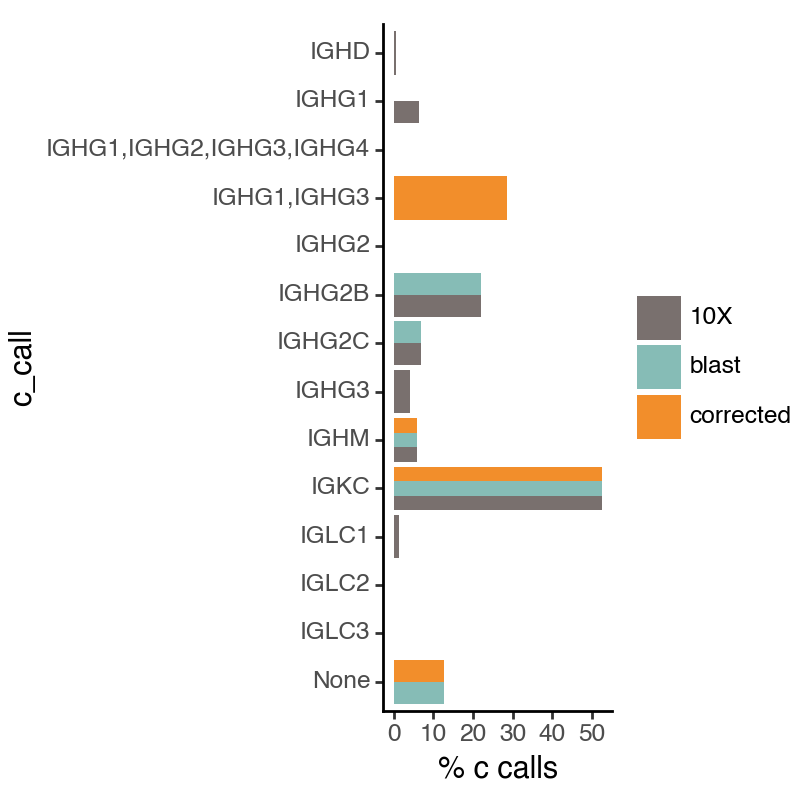

In [6]:
#assign constant region calls
ddl.pp.assign_isotypes(samples, org = "mouse")

## Load Data for analysis

In [7]:
# VDJ Data
vdj_list = []
for sample in samples:
    vdj = ddl.read_10x_airr(
        sample
        + "/dandelion/filtered_contig_dandelion.tsv"
    )
    # the dandelion output already has the sample ID prepended at the start of each contig
    vdj_list.append(vdj)
vdj = ddl.concat(vdj_list)

## V(D)J Analysis

In [8]:
# this is usually used to link vdj and gex data. We don't have any gex data but this is still required 
vdj = ddl.pp.check_contigs(vdj)

Preparing data: 2615it [00:00, 8294.05it/s]
Scanning for poor quality/ambiguous contigs: 100%|██████████| 1438/1438 [00:02<00:00, 540.71it/s]


In [9]:
# Clonotype calling
ddl.tl.find_clones(vdj)
ddl.tl.generate_network(vdj)
ddl.tl.clone_size(vdj)
ddl.tl.clone_size(vdj, max_size=3) # this makes an independent column with the provided max_size in its name

Finding clones based on B cell VJ chains : 100%|██████████| 162/162 [00:00<00:00, 16151.50it/s]
Refining clone assignment based on VJ chain pairing : 100%|██████████| 1438/1438 [00:00<00:00, 766867.03it/s]
Setting up data: 2609it [00:00, 8132.11it/s]
Linking edges : 100%|██████████| 573/573 [00:00<00:00, 1600.52it/s]


Computing network layout
Computing expanded network layout


In [10]:
# Save VDJ Data to objects that can be loaded
os.chdir('..')
if not os.path.exists('output/homotypic'):
    os.mkdir('output/homotypic')
vdj.write("output/homotypic/hometypic-vdj.h5ddl")

In [11]:
vdj = ddl.read_h5ddl("homotypic-vdj.h5ddl")

In [12]:
'''
data is stored in an object called vdj. Most of the interesting data of this object is stored in a dataframe called metadata. You can call it with 'vdj.metadata'. This datafame is a pandas object. Pandas is a really robust library independent of dandelion. This is important becuase it means that we can perform a lot of operations on this dataframe outside of dandelion if we so wish. Column names from metadata can be seen with vdj.metadata.columns. Panda dataframes can also be easily exported as a csv.
'''

vdj.metadata.to_csv('output/homotypic/homotypic_data.csv')

## Graphing Examples

(<Figure size 800x300 with 1 Axes>,
 <Axes: title={'center': 'v call VDJ usage'}, ylabel='proportion'>)

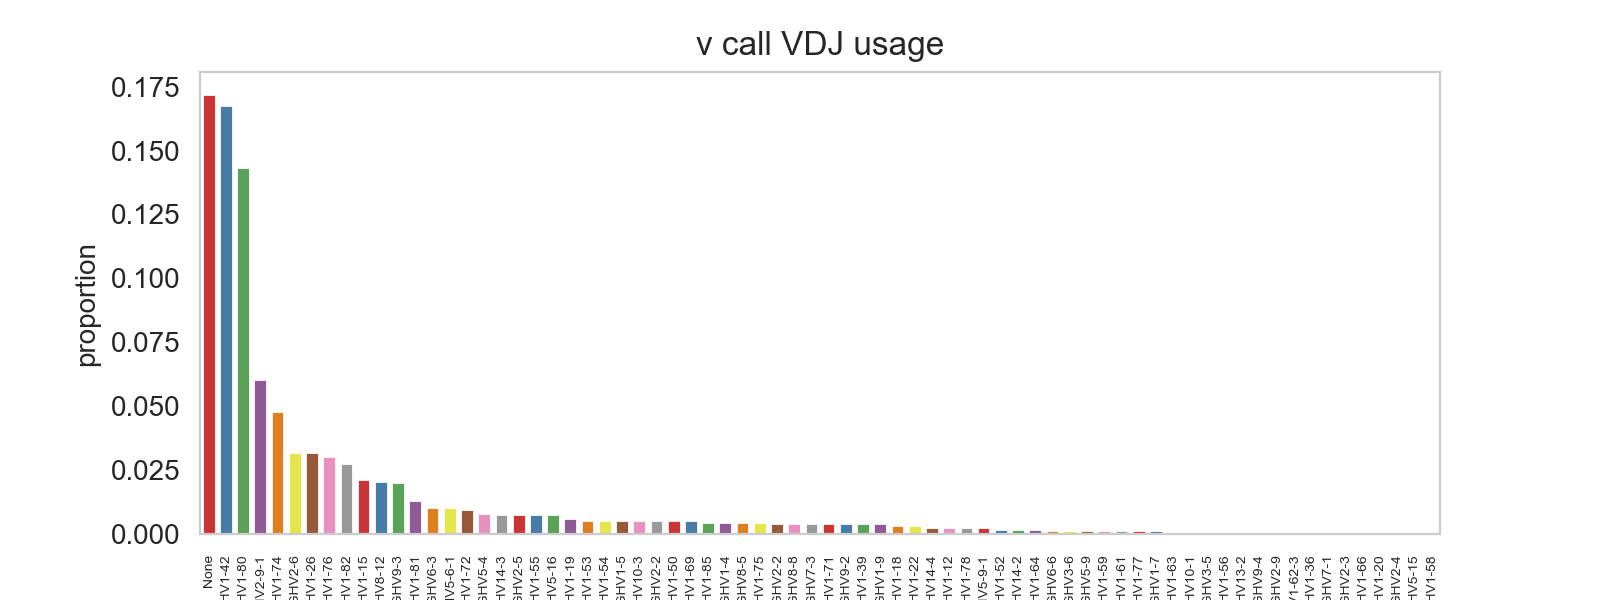

In [13]:
ddl.pl.barplot(
    vdj[vdj.metadata.isotype_status != "Multi"],  # remove multi from the plots
    color="v_call_VDJ",
    xtick_fontsize=5,
)

(<Figure size 400x300 with 1 Axes>,
 <Axes: title={'center': 'multiple stacked bar plot : isotype status usage'}, xlabel='isotype_status', ylabel='count'>)

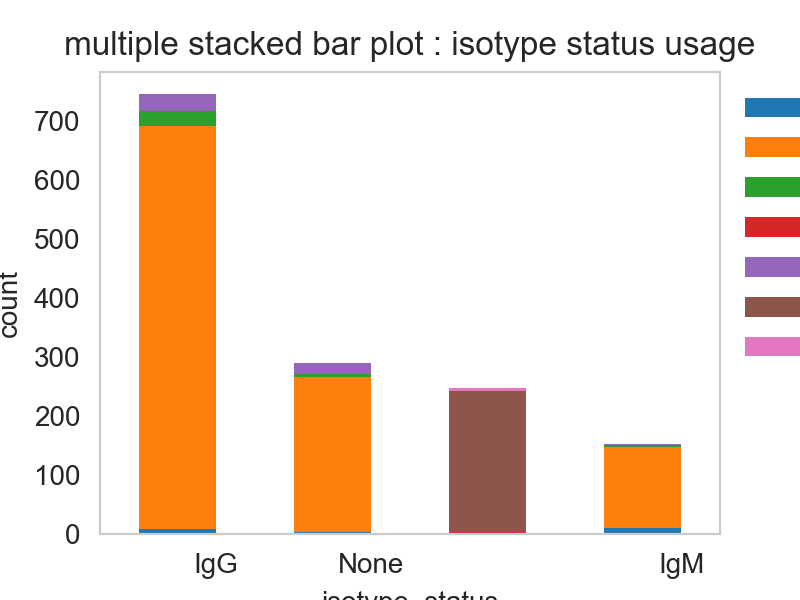

In [14]:
ddl.pl.stackedbarplot(
    vdj[vdj.metadata.isotype_status != "Multi"],
    color="isotype_status",
    groupby="locus_status",
    xtick_rotation=0,
    figsize=(4, 3),
)

(<Figure size 800x300 with 1 Axes>,
 <Axes: title={'center': 'multiple stacked bar plot : v call VDJ usage'}, xlabel='v_call_VDJ', ylabel='proportion'>)

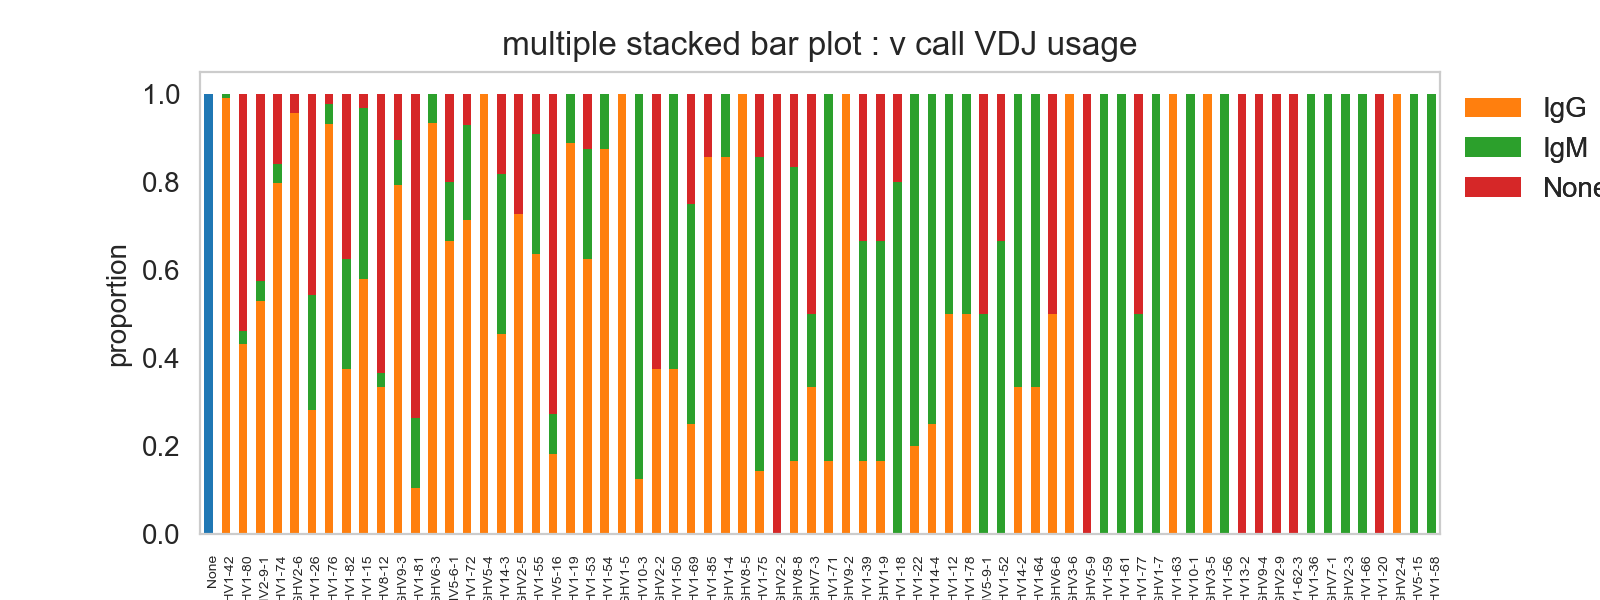

In [15]:
ddl.pl.stackedbarplot(
    vdj[vdj.metadata.isotype_status != "Multi"],
    color="v_call_VDJ",
    groupby="isotype_status",
    normalize=True,
    xtick_fontsize=5,
)

(<Figure size 500x300 with 1 Axes>,
 <Axes: xlabel='junction_length', ylabel='count'>)

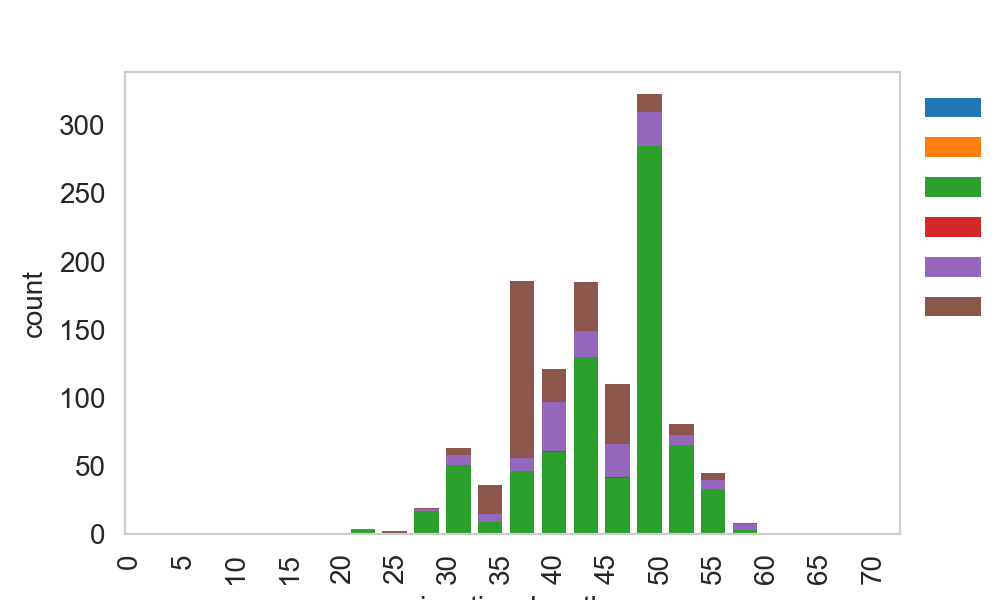

In [16]:
ddl.pl.spectratype(
    vdj[vdj.metadata.isotype_status != "Multi"],
    color="junction_length",
    groupby="c_call",
    locus="IGH",
    width=2.3,
)

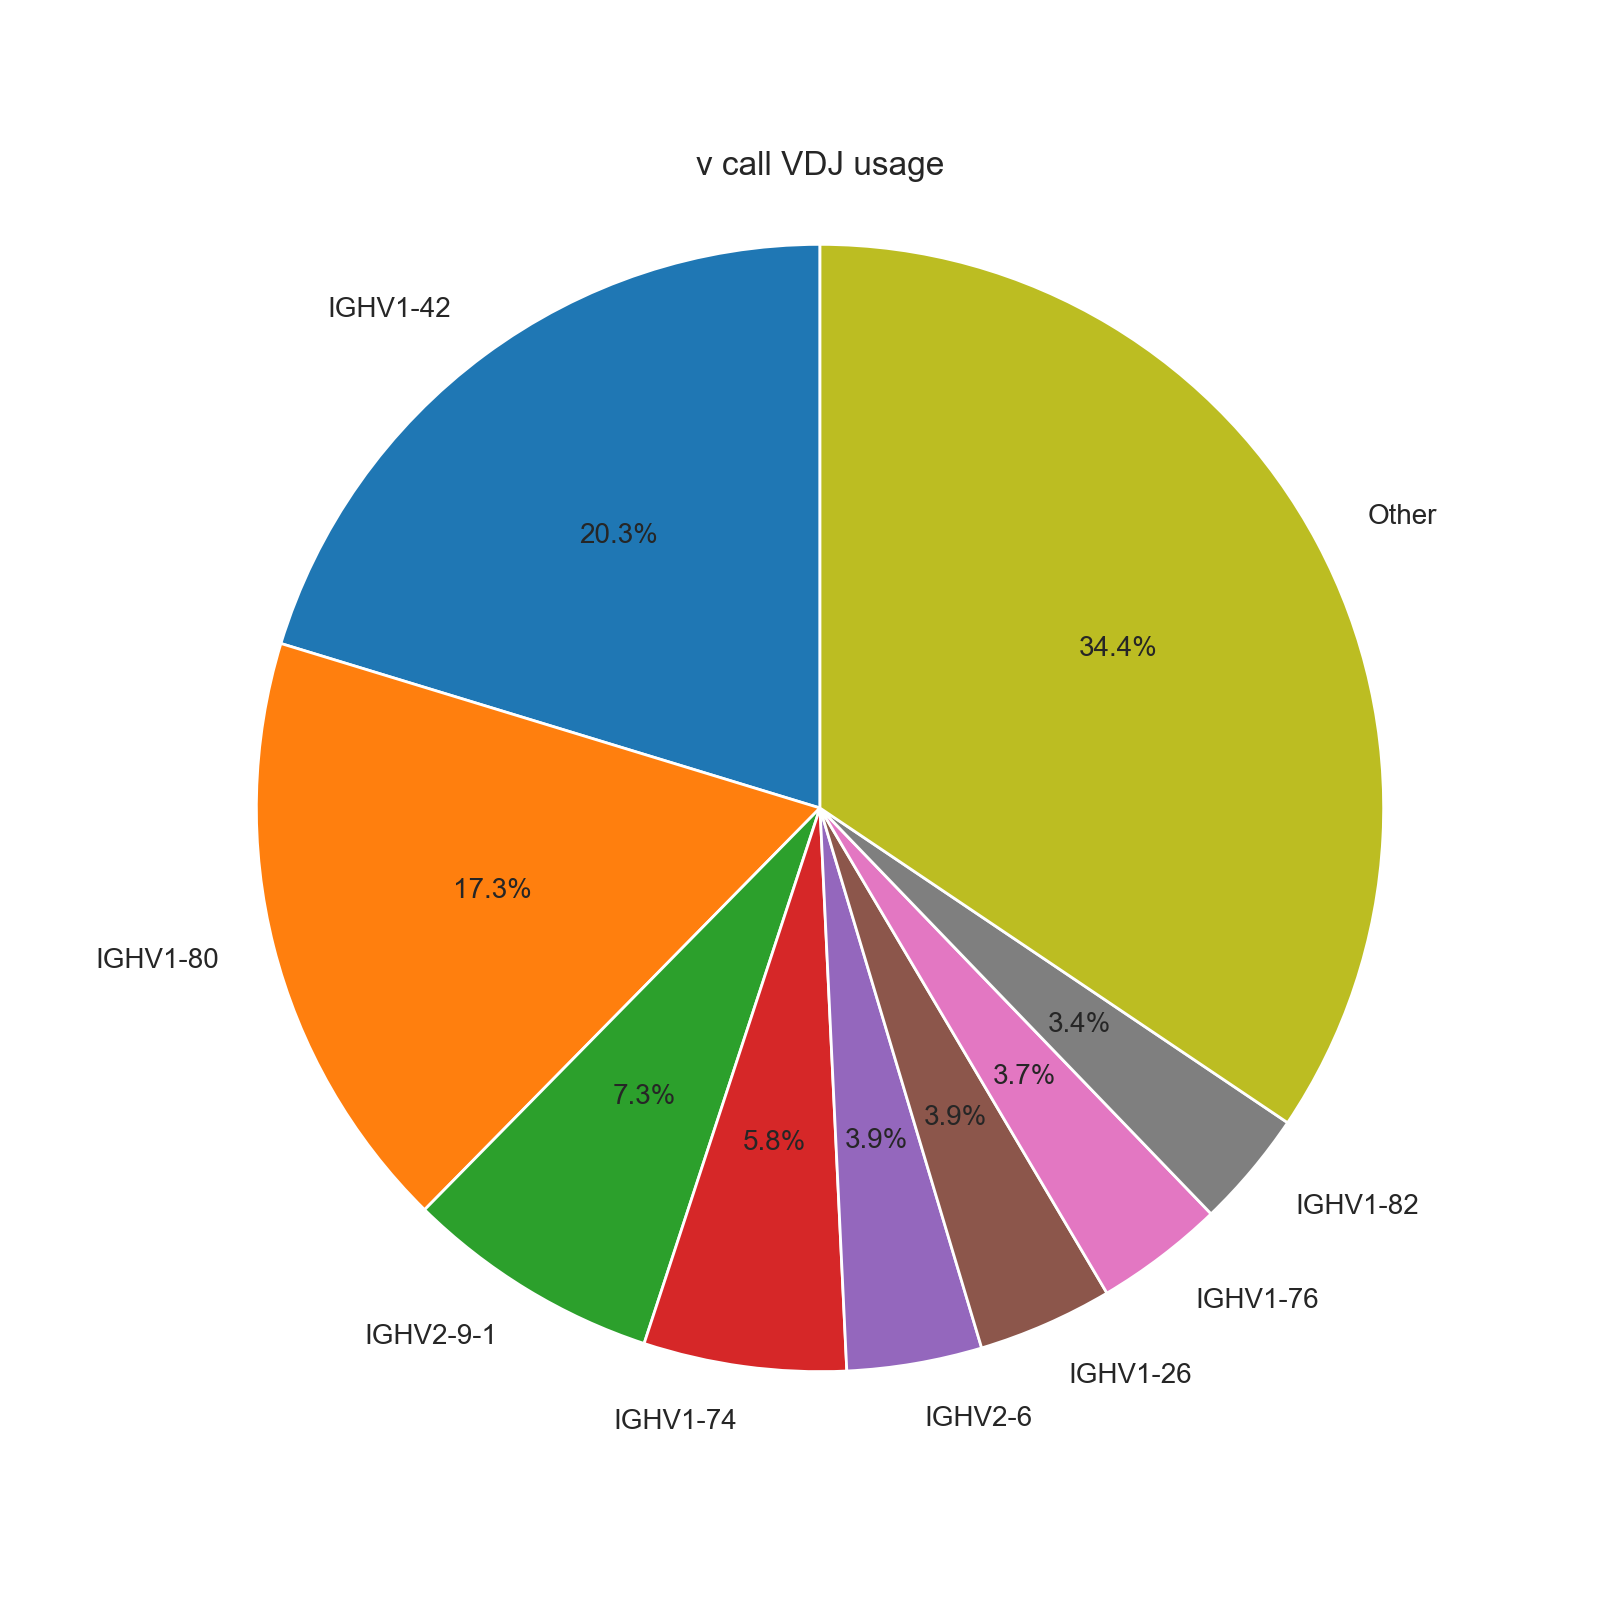

'\ndandelion is borrowing a common convention for filitering data. \'vdj.metadata\' is the data frame that contains our data of interst. isotype_status and v_call_VDJ are columns in that data frame. The expression \'vdj[vdj.metadata.isotype_status != "Multi"]\' is basically saying that we only want data from the vdj object where rows in the metadata data frame are not the word "Many" in the column isotype_status. If we want to string together filters we need to incase each statement in parentheses and join them with \'&\' within the vdj[] call. != means does not equal, == means equals. \n\n'

In [17]:
fig, ax = piechart(
    vdj[(vdj.metadata.isotype_status != "Multi") & (vdj.metadata.v_call_VDJ != "None")],  # remove multi from the plots
    color="v_call_VDJ",
    startangle=90,
    threshold = 0.03
  
)
plt.show()
'''
dandelion is borrowing a common convention for filitering data. 'vdj.metadata' is the data frame that contains our data of interst. isotype_status and v_call_VDJ are columns in that data frame. The expression 'vdj[vdj.metadata.isotype_status != "Multi"]' is basically saying that we only want data from the vdj object where rows in the metadata data frame are not the word "Many" in the column isotype_status. If we want to string together filters we need to incase each statement in parentheses and join them with '&' within the vdj[] call. != means does not equal, == means equals. 

'''